# Chapter 5 - Monte Carlo Methods
This chapter introduces MC methods, which differ from DP methods (Chapter 4) in a few key aspects:

- It learns from experience (samples of sequences of states, actions and rewards from interacting with an environment or a simulation), not from complete knowledge of the environment, i.e. the values $\mathcal{P}_{ss'}^a$ and $\mathcal{R}_{ss'}^a$ are inaccessible.

- It averages over complete returns from a given state to a terminal state, therefore the estimates for each state are independent, because it doesn't build upon the estimate of any other state, as is the case in DP. So MC doesn't bootstrap.

- If a model of the environment is not available, it is more useful to estimate action values $Q^{\pi}(s, a)$ instead of $V^{\pi}(s)$. In the former case, the optimal next action in a given state $s$ is simply calculated as $\underset{a} {\arg \max} Q(s, a)$, while knowing just $V(s)$ is not useful without being able to calculate the value of each action from that state.

### Exercise 5.1
Question on the approximate state-value functions for blackjack (Figure 5.2):

Q: Why does the value function jump up for the last two rows in the rear? <br>
A: Because when the player's sum (state) is 20 and 21, the policy prescribes _sticking_, with a high chance of a win being so close to 21. So the value of being in those states is high (if following this policy).

Q: Why does it drop off for the last row on the left? <br>
A: That corresponds to the dealer showing an _ace_, which puts it in a better position overall (as it can be used both as 1 or 11) regardless of the cards of the player. So the value of being in any of those states is correspondingly reduced for the player.

Q: Why are the frontmost values higher in the upper diagram than in the lower? <br>
A: Because all being equal, having a low sum (12, 13, ...) _with an usable ace_ is a better position for the player, since the policy prescribes _sticking_ in those states and the chances of overshooting 21 are lower due to the _ace_ potentially counted as 1.

### Exercise 5.2
What is the backup diagram for MC estimation of $Q^{\pi}$? (analogous to Figure 5.3 for $V^{\pi}$)

The backup diagram for $Q^{\pi}$ is similarly linear, since we only look at experience, i.e. pairs of $(state,\: action)$ that were actually played / simulated. The only difference is that the nodes (except the terminal state) are of a single type, which is tuples of $(state,\: action)$.

### Exercise 5.3
What is the MC estimate analogous to equation 5.3 for _action_-values of a policy $\pi$, given returns generated using $\pi'$?

First we need to redefine the variables similarly to the ones in Section 5.6, but for the complete sequence of $(state, action)$ pairs following (s, a) for the $i^{th}$ visit of $(s, a)$. Thus we define $p_i(s, a)$ the probability of the sequence of all states and actions after action $a$ in state $s$ by following policy $\pi$ and similarly $p'_i(s, a)$ the probability of the same sequence happening under policy $\pi'$. Also, let $R_i(s, a)$ be the observed return after the $i^{th}$ visit of $(s, a)$. We now need to average all $R_i(s, a)$ weighted by their relative probability of occuring under $\pi$ and $\pi'$, i.e. $\dfrac {p_i(s, a)} {p'_i(s, a)}$:

$$
Q(s, a) = \frac  {\sum_{i=1}^{n_s} \frac {p_i(s, a)}{p'_i(s, a)} R_i(s, a)} {\sum_{i=1}^{n_s} \frac {p_i(s, a)}{p'_i(s, a)}}
$$

As in the case of $V(s)$ in equation (5.3), we can show that we only need the ratio of $\dfrac {p_i(s, a)}{p'_i(s, a)}$ and not the environment's dynamics. By defining $T_i(s, a)$ as the time of termination of the $i^{th}$ episode following $(s, a)$, we have:

$$
\begin{aligned}
    p_i(s_t, a_t) &= \mathcal{P}_{s_t s_{t+1}}^{a_t} \cdot \pi(s_{t+1}, a_{t+1}) \cdot \mathcal{P}_{s_{t+1} s_{t+2}}^{a_{t+1}} \cdot \pi(s_{t+2}, a_{t+2}) \cdot \mathellipsis \cdot \mathcal{P}_{s_{T_i(s, a)-2} s_{T_i(s, a)-1}}^{a_{T_i(s, a) - 2}} \cdot \pi(s_{T_i(s, a)-1}, a_{T_i(s, a) - 1}) \cdot \mathcal{P}_{s_{T_i(s, a)-1} s_{T_i(s, a)}}^{a_{T_i(s, a) - 1}} \\ \\
    
    &= \mathcal{P}_{s_t s_{t+1}}^{a_t} \cdot \left[ \prod_{k=t+1}^{T_i(s, a) - 1} \pi(s_{k}, a_{k}) \cdot \mathcal{P}_{s_k s_{k+1}}^{a_k} \right] \\
\end{aligned}
$$

Therefore:
$$
\frac {p_i(s_t, a_t)}{p'_i(s_t, a_t)} = \frac {\mathcal{P}_{s_t s_{t+1}}^{a_t} \cdot \left[ \prod_{k=t+1}^{T_i(s, a) - 1} \pi(s_{k}, a_{k}) \cdot \mathcal{P}_{s_k s_{k+1}}^{a_k} \right]} {\mathcal{P}_{s_t s_{t+1}}^{a_t} \cdot \left[ \prod_{k=t+1}^{T_i(s, a) - 1} \pi'(s_{k}, a_{k}) \cdot \mathcal{P}_{s_k s_{k+1}}^{a_k} \right]} = \frac {\prod_{k=t+1}^{T_i(s, a) - 1} \pi(s_{k}, a_{k})} {\prod_{k=t+1}^{T_i(s, a) - 1} \pi'(s_{k}, a_{k})}
$$

which is very similar to the weight derived for $V(s)$ in the book (only difference being that index $k$ starts from $t+1$ instead of $t$, since $a_t$ is now fixed).

### Exercise 5.4

Solve the Racetrack problem. The book asks to use the __on-policy__ MC algorithm, while the Errata says to use an __off-policy__ one. So why not implement both and then compare?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [223]:
""" Some helper classes first: State and Action"""

""" State is defined by the position and velocity
    of the driver at any given time.
"""
class State:
    def __init__(self, pos_x, pos_y, v_x, v_y):
        self.pos_x = pos_x
        self.pos_y = pos_y
        self.v_x = v_x
        self.v_y = v_y

    # unique identifier for the state
    # just a concatenation of positions and velocities
    def uid(self):
        return f'{self.pos_x}_{self.pos_y}_{self.v_x}_{self.v_y}'

    def get_tuple(self):
        return (self.pos_x, self.pos_y, self.v_x, self.v_y)


""" Action is defined by the change in velocity
    of the driver at one step, given some constraints.
"""
class Action:
    def __init__(self, dv_x, dv_y):
        self.dv_x = dv_x
        self.dv_y = dv_y

    # unique identifier for the action
    # just a concatenation of delta velocities
    def uid(self):
        return f'{self.dv_x}_{self.dv_y}'

    def get_tuple(self):
        return (self.dv_x, self.dv_y)


""" Helper method to decide if a given
    action is legal in a given state s.
"""
def is_action_legal(s: State, a: Action):
    if (a.dv_x in [-1, 0, 1]
        and a.dv_y in [-1, 0, 1]
        and s.v_x + a.dv_x >= 0
        and s.v_x + a.dv_x < 5
        and s.v_y + a.dv_y >= 0
        and s.v_y + a.dv_y < 5
        and s.v_x + a.dv_x + s.v_y + a.dv_y > 0
    ):
        return True
    return False


""" Helper method to compute the list of
    all legal moves in a given state s.
"""
def action_space(s: State):
    a_s = []
    for dv_x in [-1, 0, 1]:
        for dv_y in [-1, 0, 1]:
            a = Action(dv_x, dv_y)
            if is_action_legal(s, a):
                a_s.append(a)
    return a_s


""" Helper method to return the greedy
    action uid for a given policy pi
    in a given state s (by s_uid).
"""
def greedy_action_uid(s_uid, pi):
    if s_uid in pi:
        action_uids = list(pi[s_uid].keys())
        probabilities = [pi[s_uid][a_uid]['p'] for a_uid in action_uids]
        a_max = action_uids[np.argmax(probabilities)]
        return a_max
    return None


# Now build the MDP environment
class Racetrack:
    def __init__(self, track, state: State):
        # the track is an (m, n) array
        # that contains one of the following:
        # 0 := off-track
        # 1 := on-track 
        # 2 := starting line
        # 3 := finish line
        self.track = track
        # the current position and velocity of the agent
        self.s = state

    def step(self, a: Action):
        assert is_action_legal(self.s, a), 'illegal action'

        # probabilitistic noise (e.g. drifting)
        drift = np.random.binomial(n=1, p=0.5)  # whether this step it drifts
        drift_x = np.random.binomial(n=1, p=0.5)  # vertical drift
        drift_y = 1 - drift_x  # horizontal drift
        drift_x *= drift
        drift_y *= drift

        cx, cy = self.s.pos_x, self.s.pos_y  # current cell coords (int)
        fx, fy = self.s.pos_x, self.s.pos_y  # current fractional position (float)

        # new velocity for the current step, including stochastic noise (drift)
        dx, dy = (self.s.v_x + a.dv_x + drift_x), (self.s.v_y + a.dv_y + drift_y)

        # start moving by small steps towards next state
        # such as to identify all intersections
        fractional_steps = 50
        for _ in range(1, fractional_steps + 1):
            # move by small steps to identify intersections
            fx += dx / fractional_steps
            fy += dy / fractional_steps
            if np.isclose(np.modf(fx)[0], 0.5) or np.isclose(np.modf(fy)[0], 0.5):
                continue  # we are either in a diagonal corner, or on a boundary, move on
            else:
                if np.round(fx) == cx and np.round(fy) == cy:
                    continue  # we are in the same current cell, move on
                else:
                    # we're in a new cell
                    potential_cx, potential_cy = int(np.round(fx)), int(np.round(fy))
                    if (potential_cx >= 0 and potential_cx < self.track.shape[0]
                        and potential_cy >= 0 and potential_cy < self.track.shape[1]):
                        # we are inside the track matrix
                        if self.track[potential_cx, potential_cy] == 3:
                            # passed the finish line
                            self.s = State(potential_cx, potential_cy, self.s.v_x + a.dv_x, self.s.v_y + a.dv_y)
                            return dict(r=-1., s=self.s, terminal=True)
                        elif self.track[potential_cx, potential_cy] == 0:
                            # off-track
                            self.s = State(cx, cy, self.s.v_x + a.dv_x, self.s.v_y + a.dv_y)
                            return dict(r=-5., s=self.s, terminal=False)
                        else:
                            # on-track
                            cx, cy = potential_cx, potential_cy
                            continue
                    else:
                        # outside the matrix, same as off-track:
                        self.s = State(cx, cy, self.s.v_x + a.dv_x, self.s.v_y + a.dv_y)
                        return dict(r=-5., s=self.s, terminal=False)
        self.s = State(cx, cy, self.s.v_x + a.dv_x, self.s.v_y + a.dv_y)
        return dict(r=-1., s=self.s, terminal=False)

In [142]:
# from Figure 5.8 - just upside down
track1 = np.array([
    [0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
])

track2 = np.array([
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
])

In [149]:
""" Generate an episode on a given track
    by following policy pi from a random
    point on the starting line and zero
    initial velocity. Policy pi is a
    dictionary {s: {a: prob, ...}, ...}.
    If a given state / action are not in
    pi, they are added on the fly and assigned
    uniform probability. Potentially mutated
    pi is then returned at the end. The action
    selection is either greedy i.e. argmax_a[pi(s)]
    or randomly from the distribution ~ pi(s, a).
"""
def generate_episode(track, pi, greedy=False, store_transitions=False):
    transitions = []
    # choose a random starting point
    starting_points = np.where(track == 2)
    len_starting_points = len(starting_points[0])
    random_start = np.random.choice(len_starting_points)
    start_pos_x, start_pos_y = starting_points[0][random_start], starting_points[1][random_start]

    # init state and environment
    s = State(start_pos_x, start_pos_y, 0, 0)
    env = Racetrack(track=track, state=s)

    step = 0
    terminal = False
    R = dict()  # returns
    v_x, v_y = 0, 0

    # limit episode length to 50
    while not terminal and step < 50:
        s_uid = s.uid()
        if s_uid not in pi:
            pi[s_uid] = dict()

        if len(pi[s_uid]) == 0:
            # init with uniform probability across all legal actions
            a_s = action_space(s)
            for a in a_s:
                pi[s_uid][a.uid()] = dict(action=a, p=1. / len(a_s))

        # choose an action according to policy probs
        action_uids = list(pi[s_uid].keys())
        probabilities = [pi[s_uid][a_uid]['p'] for a_uid in action_uids]
        if greedy:
            a_uid = action_uids[np.argmax(probabilities)]
        else:
            a_uid = np.random.choice(action_uids, p=probabilities)
        a = pi[s_uid][a_uid]['action']

        # first time reached s
        if s_uid not in R:
            R[s_uid] = dict()

        # first time reached (s, a)
        if a_uid not in R[s_uid]:
            R[s_uid][a_uid] = 0.

        # make a move
        next = env.step(a)

        # add reward to all previous states reached in the episode
        for s_uid in R:
            for a_uid in R[s_uid]:
                R[s_uid][a_uid] += next['r']  # undiscounted

        terminal = next['terminal']
        # print(f"s={s.get_tuple()}, a={a.get_tuple()}, r={next['r']}, s'={next['s'].get_tuple()}, terminal={terminal}")
        if store_transitions:
            transitions.append((s.get_tuple(), a.get_tuple(), next['r'], next['s'].get_tuple(), terminal))
        s = next['s']
        step += 1
    return R, pi, transitions

__On-policy MC__

In [152]:
""" On-policy Monte Carlo learning algorithm
    track := it defines the environment, an (m, n) array
    episodes := number of episodes to generate and learn from
    epsilon := for the epsilon-soft policy pi
    alpha := coeff. to calculate Q on the fly instead of sample averages
            This simplifies the update of Q, as we don't have to store
            the list of all returns R for every (s, a) ever visited.
"""
def on_policy_MC_learning(track, episodes=1000, epsilon=0.2, alpha=0.1):
    pi = dict()  # start with a random, uniform policy
    Q = dict()

    for e in range(episodes):
        R, pi, _ = generate_episode(track=track, pi=pi)

        for s_uid in R:
            if s_uid not in Q:
                Q[s_uid] = dict()

            for a_uid in pi[s_uid]:
                if a_uid not in Q[s_uid]:
                    Q[s_uid][a_uid] = 0.  # optimistic initialisation; helps exploration
                if a_uid in R[s_uid]:
                    Q[s_uid][a_uid] = (1. - alpha) * Q[s_uid][a_uid] + alpha * R[s_uid][a_uid]

        for s_uid in R:
            a_star = None
            q_max = -99999.
            a_len = len(Q[s_uid])
            for a_uid in Q[s_uid]:
                pi[s_uid][a_uid]['p'] = epsilon / a_len
                if Q[s_uid][a_uid] > q_max:
                    q_max = Q[s_uid][a_uid]
                    a_star = a_uid
            pi[s_uid][a_star]['p'] += 1 - epsilon
    return pi

In [204]:
# these take about 10 min for 5k+5k episodes
# learn a policy for track1
pi1 = on_policy_MC_learning(track1, episodes=5000)
# learn a policy for track2
pi2 = on_policy_MC_learning(track2, episodes=5000)

In [208]:
# Use policies pi1 and pi2 to generate 5 trajectories
# of the driver on each of the two tracks.
played_track1 = []
for i in range(5):
    _, _, transitions = generate_episode(track1, pi1, greedy=True, store_transitions=True)
    # mark the positions of the agent on the track diagram
    played_track1.append(track1.copy())
    for t in transitions:
        played_track1[i][t[0][0], t[0][1]] = 4
    played_track1[i][t[3][0], t[3][1]] = 4

played_track2 = []
for i in range(5):
    _, _, transitions = generate_episode(track2, pi2, greedy=True, store_transitions=True)
    # mark the positions of the agent on the track diagram
    played_track2.append(track2.copy())
    for t in transitions:
        played_track2[i][t[0][0], t[0][1]] = 4
    played_track2[i][t[3][0], t[3][1]] = 4

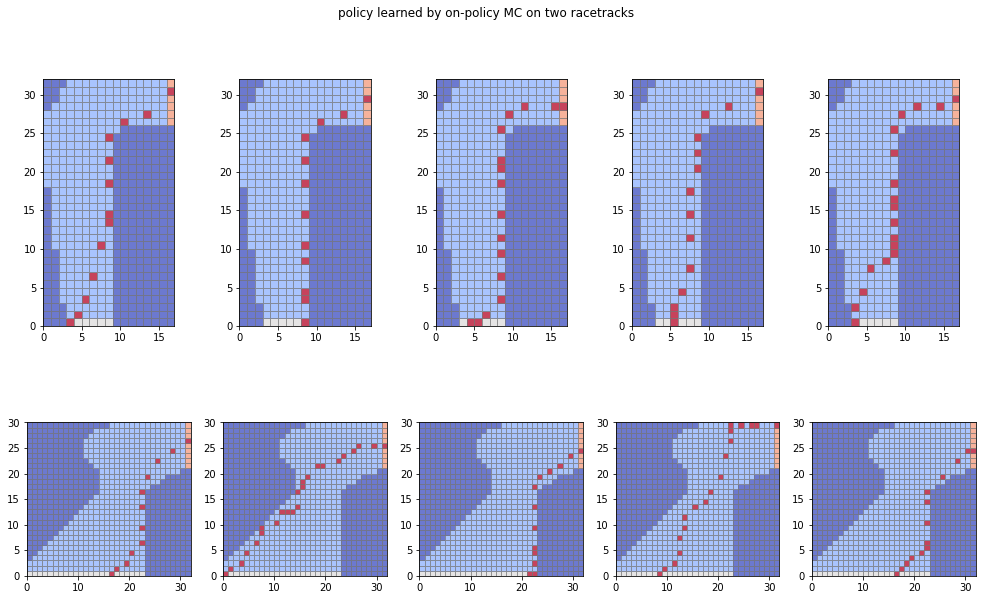

In [210]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(17, 10))
for i in range(5):
    ax[0][i].pcolormesh(played_track1[i], edgecolors='gray', linewidth=1, alpha = 0.75, cmap='coolwarm')
    ax[0][i].set_aspect('equal')
for i in range(5):
    ax[1][i].pcolormesh(played_track2[i], edgecolors='gray', linewidth=1, alpha = 0.75, cmap='coolwarm')
    ax[1][i].set_aspect('equal')
fig.suptitle('policy learned by on-policy MC on two racetracks')
plt.show()

So on-policy MC manages to find near-optimal policies in 5000 episodes. Let's see how off-policy MC does below.

__Off-policy MC__

In [256]:
""" Off-policy Monte Carlo learning algorithm
    track := it defines the environment, an (m, n) array
    episodes := number of episodes to generate and learn from
    pi_b := behaviour policy (epsilon-soft), the one used to generate episodes
    pi := initial estimation policy (deterministic, greedy), the one we're learning
    returns mutated pi
"""
def off_policy_MC_learning(track, episodes=1000, pi_b=None, pi=None):
    if pi_b is None:
        pi_b = {}
    if pi is None:
        pi = {}

    Q = {}
    N = {}
    D = {}

    for e in range(episodes):
        _, pi_b, transitions = generate_episode(track=track, pi=pi_b, greedy=False, store_transitions=True)
        R = 0.
        w = 1.
        N_tmp = {}
        D_tmp = {}
        T = len(transitions)
        t = T-1
        tail_is_longer = True
        # move backwards through the tail
        while t >= 0 and tail_is_longer:
            transition = transitions[t]
            # transition is a tuple like ((s), (a), r, (next_s), terminal)
            # fragile reconstruction of uid's, could be improved
            s_uid = '_'.join([str(i) for i in transition[0]])  # state
            a_uid = '_'.join([str(i) for i in transition[1]])  # action
            R += transition[2]  # total return from t to T

            if s_uid not in N_tmp:
                N_tmp[s_uid] = {}
                D_tmp[s_uid] = {}
            # possibly overwritten if same (s, a) was visited earlier!
            # as this is a first-visit MC algorithm
            N_tmp[s_uid][a_uid] = w * R
            D_tmp[s_uid][a_uid] = w

            w *= 1. / pi_b[s_uid][a_uid]['p']

            greedy_uid = greedy_action_uid(s_uid, pi)
            if (s_uid not in pi) or (greedy_uid is None) or (greedy_uid != a_uid):
                    # stop, cut tail here
                    tail_is_longer = False
            t -= 1

        # update Q values for all (s, a) seen in the tail
        for s_uid in N_tmp:
            if s_uid not in N:
                N[s_uid] = {}
                D[s_uid] = {}
                Q[s_uid] = {}
            for a_uid in N_tmp[s_uid]:
                if a_uid not in N[s_uid]:
                    N[s_uid][a_uid] = 0.
                    D[s_uid][a_uid] = 0.
                    Q[s_uid][a_uid] = 0.
                N[s_uid][a_uid] += N_tmp[s_uid][a_uid]
                D[s_uid][a_uid] += D_tmp[s_uid][a_uid]
                Q[s_uid][a_uid] = N[s_uid][a_uid] / D[s_uid][a_uid]
        
        # update pi
        for s_uid in Q:
            q_max = -99999.
            a_max = None
            for a_uid in Q[s_uid]:
                if Q[s_uid][a_uid] > q_max:
                    a_max = a_uid
                    q_max = Q[s_uid][a_uid]
            if s_uid not in pi:
                pi[s_uid] = {}
            for a_uid in Q[s_uid]:
                if a_uid not in pi[s_uid]:
                    dv_x, dv_y = str.split(a_uid, '_')  # fragile, could be improved
                    pi[s_uid][a_uid] = dict(p=0., action=Action(int(dv_x), int(dv_y)))
            for a_uid in pi[s_uid]:
                pi[s_uid][a_uid]['p'] = 0.
            pi[s_uid][a_max]['p'] = 1.
    return pi

In [236]:
# these take about 15 min for 5k + 5k episodes
pi1_off = off_policy_MC_learning(track1, episodes=5000)
pi2_off = off_policy_MC_learning(track2, episodes=5000)

In [244]:
# Use policies pi1_off and pi2_off to generate 5 trajectories
# of the driver on each of the two tracks.
played_track1 = []
for i in range(5):
    _, _, transitions = generate_episode(track1, pi1_off, greedy=True, store_transitions=True)
    # mark the positions of the agent on the track diagram
    played_track1.append(track1.copy())
    for t in transitions:
        played_track1[i][t[0][0], t[0][1]] = 4
    played_track1[i][t[3][0], t[3][1]] = 4

played_track2 = []
for i in range(5):
    _, _, transitions = generate_episode(track2, pi2_off, greedy=True, store_transitions=True)
    # mark the positions of the agent on the track diagram
    played_track2.append(track2.copy())
    for t in transitions:
        played_track2[i][t[0][0], t[0][1]] = 4
    played_track2[i][t[3][0], t[3][1]] = 4

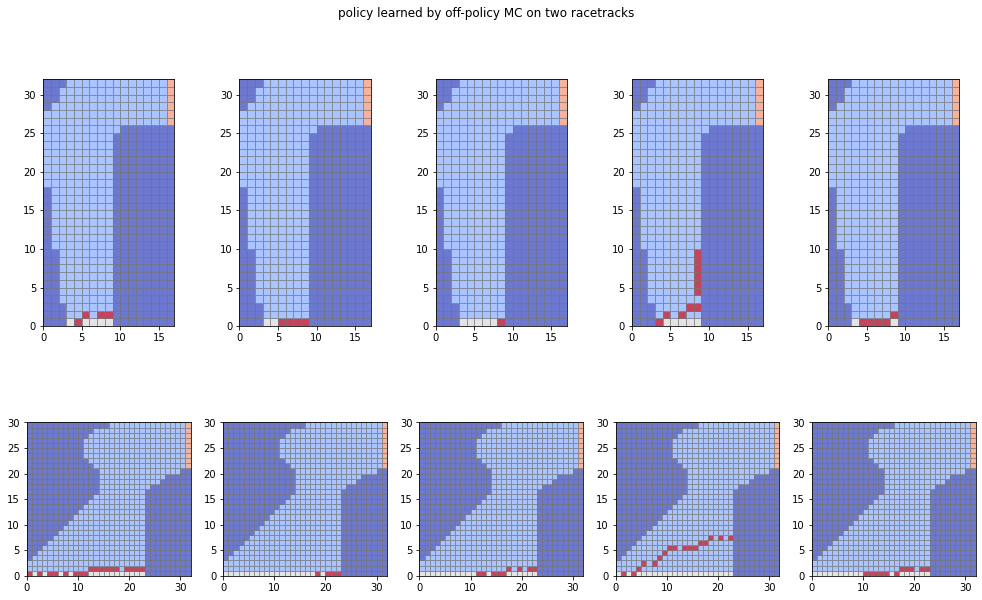

In [245]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(17, 10))
for i in range(5):
    ax[0][i].pcolormesh(played_track1[i], edgecolors='gray', linewidth=1, alpha = 0.75, cmap='coolwarm')
    ax[0][i].set_aspect('equal')
for i in range(5):
    ax[1][i].pcolormesh(played_track2[i], edgecolors='gray', linewidth=1, alpha = 0.75, cmap='coolwarm')
    ax[1][i].set_aspect('equal')
fig.suptitle('policy learned by off-policy MC on two racetracks')
plt.show()

Notice how after 5000 episodes, neither track was solved by the off-policy method, as compared to the successful on-policy one.

I believe that learning from tails is very inefficient for this exercise, as mentioned at the end of Section 5.6, due to the large $(state, action)$ space. Indeed, very few optimal actions from $\pi(s)$ have been found, most of them very close to the finish line, a phenomenon which reflects the nature of this methods that learns from tails only. Let's train from some more episodes, just for <code>track1</code>.

In [247]:
# this takes another 15 min for 10k additional episodes
pi1_off = off_policy_MC_learning(track1, episodes=10_000, pi_b=None, pi=pi1_off)

In [259]:
# Use policy pi1_off to generate 5 trajectories
# of the driver on track1.
played_track1 = []
for i in range(5):
    # Although the policy is greedy, we use greedy=False here because
    # it didn't manage to visit the whole (s, a) space.
    # So if pi(s, a) = 1 (learned), it uses that action,
    # otherwise it selects a legal action uniformly.
    _, _, transitions = generate_episode(track1, pi1_off, greedy=False, store_transitions=True)
    # mark the positions of the agent on the track diagram
    played_track1.append(track1.copy())
    for t in transitions:
        played_track1[i][t[0][0], t[0][1]] = 4
    played_track1[i][t[3][0], t[3][1]] = 4

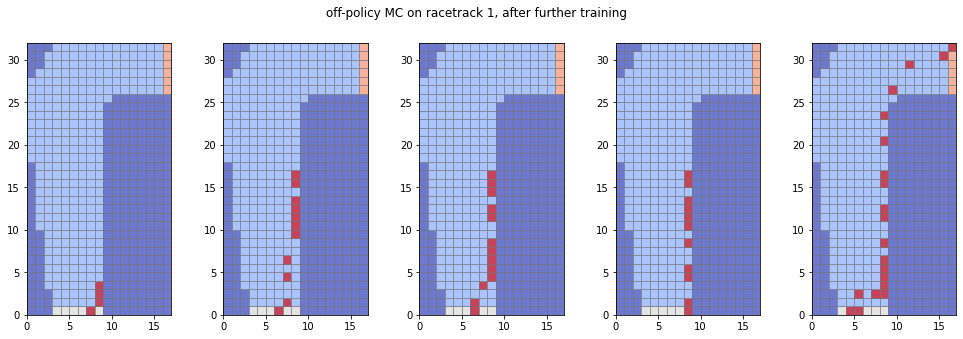

In [260]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(17, 5))
for i in range(5):
    ax[i].pcolormesh(played_track1[i], edgecolors='gray', linewidth=1, alpha = 0.75, cmap='coolwarm')
    ax[i].set_aspect('equal')
fig.suptitle('off-policy MC on racetrack 1, after further training')
plt.show()

This is somewhat better, but it still gets stuck midway and doesn't find the optimal policy. 

### Exercise 5.5
Modify the algorithm for first-visit MC policy evaluation (Figure 5.1) to use the incremental implementation for sample averages described in Section 2.5.

Quick reminder, in Section 2.5 we were given a proof that in order to calculate a sample average for some value $Q_k = \dfrac {r_1 + r_2 + \mathellipsis + r_k} {k}$ we don't need to store all values of $r_i$ in memory, but can efficiently hold the current estimate $Q_{k}$ and a counter $k$, then use the relationship:

$$
    Q_{k+1} = Q_k + \frac {1} {k+1} \left[ r_{k+1} - Q_k \right]
$$
Thus the algorithm in Figure 5.1 can be improved in terms of memory requirements by not storing the full history of _Returns_ $(s)$:

$$
\boxed{
\begin{aligned}
    &\large \text {Initialize:} \\
    &\qquad \pi \leftarrow \text {policy to be evaluated} \\
    &\qquad V \leftarrow \text {an arbitrary state-value function} \\
    &\qquad Visits(s) \leftarrow 0 \text {, for all } s \in \mathcal{S} \\
    \\
    &\large \text {Repeat forever:} \\
    &\qquad \text {(a) Generate an episode using } \pi \\
    &\qquad \text {(b) For each state } s \text { appearing in the episode} \\
    &\qquad \qquad R \leftarrow \text {return following the first occurrrence of } s \\
    &\qquad \qquad V(s) \leftarrow V(s) + \frac {1} {Visits(s) + 1} \left[ R - V(s) \right] \\
    &\qquad \qquad Visits(s) \leftarrow Visits(s) + 1 \\
\end{aligned}
}
$$